In [1]:
import torch
import os
from importlib import import_module

In [2]:
# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3
class UnNormalize():
    """정규화 되었던 이미지를 복원하는 Transforms Function.

    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [3]:
def load_model(saved_model, model:str, num_classes, device, **kwargs):
    model_cls = getattr(import_module("model"), model)
    model = model_cls(
        num_classes=num_classes,
        # 아래는 model에 추가적인 파라미터가 필요할 때 사용하시면 됩니다.
        # **kwargs
    )

    model_path = os.path.join(saved_model, 'best.pth')
    model.load_state_dict(torch.load(model_path, map_location=device))

    return model

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

def inference_model(loader, model_dir, model:str, num_classes, break_idx=300, **kwargs) -> list:
    """Confusion Matrix 출력 함수.

    Args:
        loader (dataloader)): dataloader
        model_dir (str): 저장된 모델 경로.
        num_classes (int): 클래스 갯수
        model (str): 모델 클래스명. 단, 문자열로 줘야 함.
        break_idx (int, optional): 모두 다 inference하는 것은 너무 오래 걸려서 끊어주기 위한 장치를 마련. Defaults to 300.
        **kwargs : 모델에 들어가게 되는 추가적인 파라미터들.
    Returns:
        list: 튜플 (wrong_imgs, wrong_answers, wrong_labels)을 담아낸 리스트. 이미지에 종속된 라벨을 한꺼번에 묶음.
    """
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    model = load_model(model_dir, model, num_classes, device, **kwargs).to(device)
    model.eval()

    print(f"Calculating inference results for {model_dir}..")
    
    answers = []
    preds = []
    
    # 오답 처리된 이미지들에 대해 (이미지, 정답, 오답)을 출력하기 위한 과정들.
    wrong_imgs, wrong_answers, wrong_labels = [], [], []
    with torch.no_grad():
        for idx, (images, labels) in enumerate(tqdm(loader)):
            # <계산 과정>
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1).cpu()
            # </계산 과정>
            
            answers.extend(labels)
            preds.extend(pred.numpy()) 
            
            # 오답 판별 과정.
            wrong_ans = (pred != labels)
            
            # 오답 판별 결과 누적.
            wrong_imgs.extend(images[wrong_ans].cpu())
            wrong_answers.extend(labels[wrong_ans].cpu())
            wrong_labels.extend(pred[wrong_ans].cpu())
            
            if idx >= break_idx:
                break

    ax = plt.subplot(1,1,1)
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    # sklearn.metrics에서의 confusion_matrix 메서드 사용.
    cf_matrix = confusion_matrix(answers, preds, labels=list(range(num_classes)))
    sns.heatmap(cf_matrix, annot=True)
    
    # confusion_matrix의 첫 파라미터는 y축으로 두 번째 파라미터는 x축으로 감.
    plt.xlabel('pred', fontsize=14)
    plt.ylabel('answer', fontsize=14)
    
    return list(zip(wrong_imgs, wrong_answers, wrong_labels))

In [5]:
import matplotlib.pyplot as plt
from einops import rearrange
import random

def show(pic, num=20, mean_std=None):
    """Confusion Matrix 출력을 위한 공간.

    Args:
        pic (List:[tuple(wrong_imgs, wrong_answers, wrong_labels)]): inference_model의 결과값.
        num (int, optional): 출력하고 싶은 이미지 갯수. Defaults to 20.
        mean_std (tuple, optional): ((Mean), (Std))). Defaults to None.
    """
    # 출력할 때마다 다른 이미지 보여지도록 추가한 라인.
    pic = random.choices(list(pic), k=num)
    
    for idx, (img, true, pred) in enumerate(pic):
        # 위에서 random.choices로 갯수 제한해서 필요없긴 한데 갯수 제한없이 출력했을 때,
        # 컴퓨터 터질 뻔해서 이중으로 대비했습니다.
        if idx >= num:
            break
        
        # plt.imshow는 (H, W, C)만 출력 가능해서 추가한 라인.
        img = rearrange(img, 'c h w -> h w c')
        
        # UnNormalize를 위해 추가한 코드.
        if mean_std:
            trfm = UnNormalize(*mean_std)
            img = trfm(img)
        
        # 이미지 출력 코드.
        plt.imshow(img)
        plt.title(f'num: {idx+1} answer: {true}, pred: {pred}')
        plt.axis('off')
        plt.show()

---

아래부터가 실질적으로 사용되는 부분입니다.

---

In [6]:
from dataset import MaskSplitByProfileDataset, UniformDataset, CustomAugmentation, BaseAugmentation, UniGakGakDataset

######### inference를 위한 데이터셋
uni = MaskSplitByProfileDataset('/opt/ml/input/data/train/images')
# uni = UniGakGakDataset('/opt/ml/input/data/train/images', label_type='age')

######### inference를 위한 데이터셋의 set_transform
# uni.set_transform(CustomAugmentation((384, 512), mean=1.0, std=1.0))
uni.set_transform(BaseAugmentation((384, 512), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)))

######### inference를 위한 데이터셋의 DataLoader
DL = torch.utils.data.DataLoader(uni, batch_size=10, shuffle=False)

  0%|          | 0/1890 [00:00<?, ?it/s]

Calculating inference results for /opt/ml/workspace/saved/UniGakGakDataset_BaseAugmentation_ResNetModel_SGD/age..


 16%|█▌        | 300/1890 [00:51<04:35,  5.78it/s]


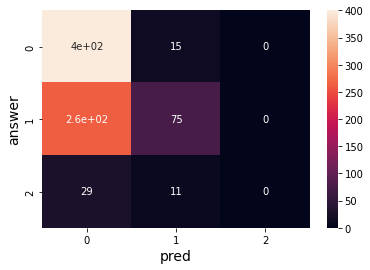

In [7]:
x = inference_model(
    # dataloader
    DL, 
    # model_dir
    '/opt/ml/workspace/saved/UniGakGakDataset_BaseAugmentation_ResNetModel_SGD/age', 
    # model:str
    "ResNetModel",
    
    num_classes=3, 
    
    break_idx=300,
    
    # 아래는 모델에 들어가야 할 추가적인 파라미터를 위해 만들었습니다.
    # **kwargs
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


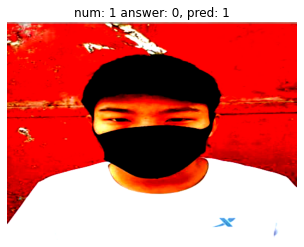

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


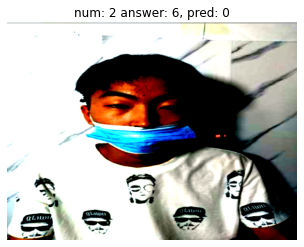

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


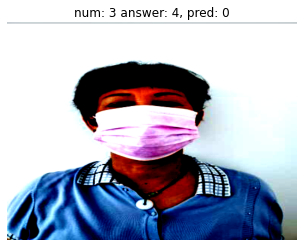

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


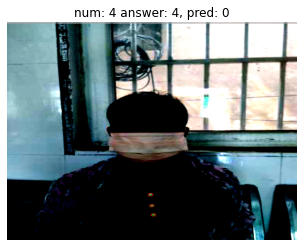

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


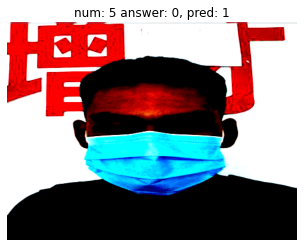

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


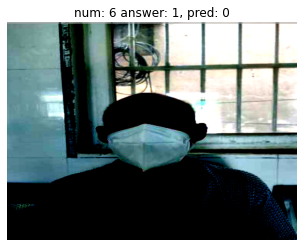

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


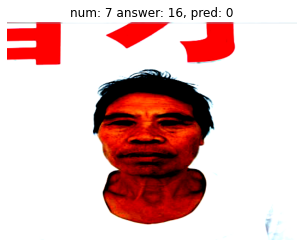

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


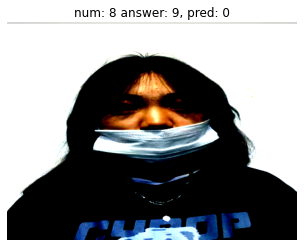

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


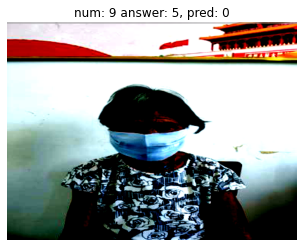

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


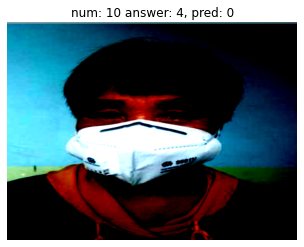

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


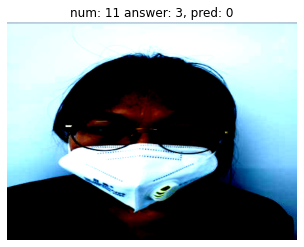

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


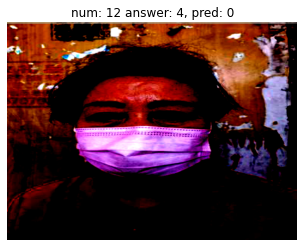

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


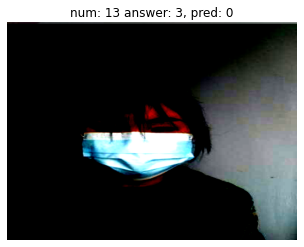

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


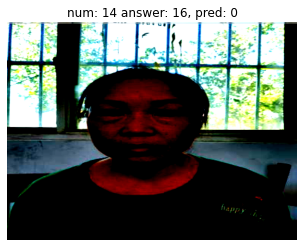

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


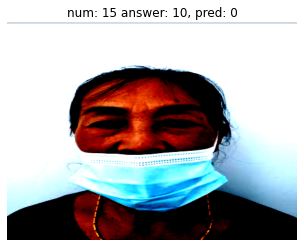

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


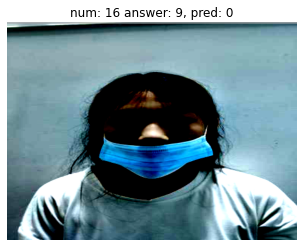

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


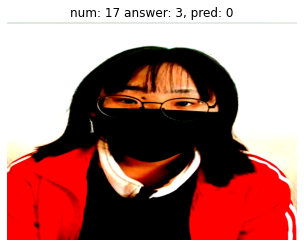

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


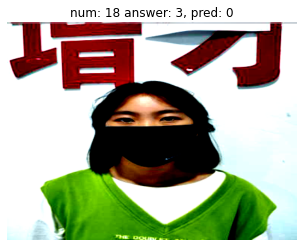

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


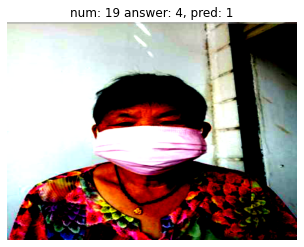

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


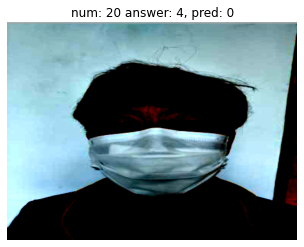

In [8]:
show(
    # inference_model 결과값
    x, 
    # 출력하고 싶은 갯수.
    num=20, 
    # UnNormalize에 사용될 값들.
    mean_std=((0.548, 0.504, 0.479), (0.237, 0.247, 0.246))
    )